#### Домашнее задание к лекции №3

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix
from xgboost import XGBClassifier

In [2]:
path = 'train_case2.csv'

In [3]:
df = pd.read_csv(path, sep=';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

C:\Users\effg\AppData\Local\Temp\ipykernel_8992\1317150810.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1),


Трансформируем колонки в Pipeline'ах  
К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame 
    to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame 
    to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                            ('selector', NumberSelector(key=cont_col)),
                            ('standard', StandardScaler())
                            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                                ('selector', ColumnSelector(key=cat_col)),
                                ('ohe', OHEEncoder(key=cat_col))
                                ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                                ('selector', NumberSelector(key=base_col))
                                ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion и заупстим трансформацию

In [7]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

x_train = feature_processing.fit_transform(X_train)
x_test = feature_processing.fit_transform(X_test)

Посчитаем precision/recall/f_score/roc_auc

In [8]:
def get_scores(y_true, 
               y_predicted, 
               f_score_b=1, 
               title='Confusion matrix', 
               classes=['cardio_0', 'cardio_1'], 
               normalize=False):
    """
    calculate:
    - precision
    - recall
    - fscore
    - roc-auc
    - confusion matrix
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_predicted)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    roc_auc = roc_auc_score(y_true, y_predicted)
    log_loss_score = log_loss(y_true, y_predicted)
    
    cm = confusion_matrix(y_true, y_predicted)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    TNR = TN/(FP+TN)
    print(f'\
Precision = {precision[ix]:.3f}\n\
Recall    = {recall[ix]:.3f}\n\
F-score   = {fscore[ix]:.3f}\n\
ROC_AUC   = {roc_auc:.3f}\n\
Log_loss  = {log_loss_score:.3f}\n\
True_pos  = {TPR:.3f}\n\
False_pos = {FPR:.3f}\n\
True_neg  = {TNR:.3f}\n')

    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_true, y_predicted, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()
    
    font = {'size' : 15}
    plt.rc('font', **font)
    plt.figure(figsize=(10, 8))
    cmap = plt.cm.Blues
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.rcParams['axes.grid'] = False
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return {
            'Precision': precision[ix],
            'Recall': recall[ix],
            'F-score': fscore[ix],
            'ROC_AUC': roc_auc,
            'Log_loss': log_loss_score,
            'True_pos': TPR,
            'False_pos': FPR,
            'True_neg': TNR
            }

Основной цикл обучения моделей

LogisticRegression
Наилучшие параметры {'C': 100.0, 'penalty': 'l2'}
mean y_score is  0.46
Precision = 0.734
Recall    = 0.680
F-score   = 0.706
ROC_AUC   = 0.719
Log_loss  = 9.697
True_pos  = 0.680
False_pos = 0.242
True_neg  = 0.758



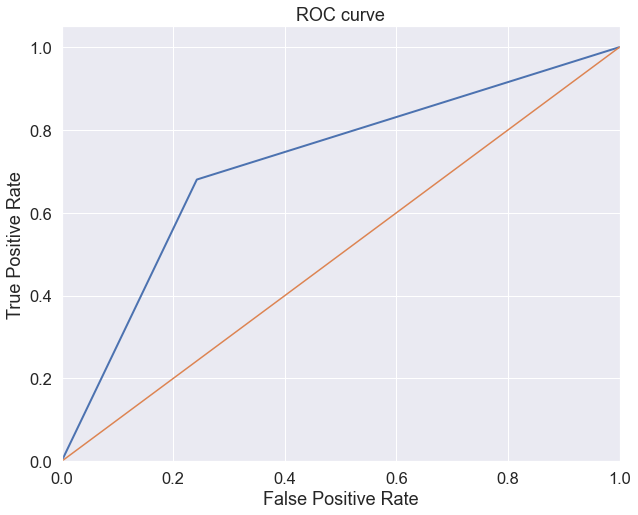

Confusion matrix, without normalization
[[6682 2138]
 [2775 5905]]


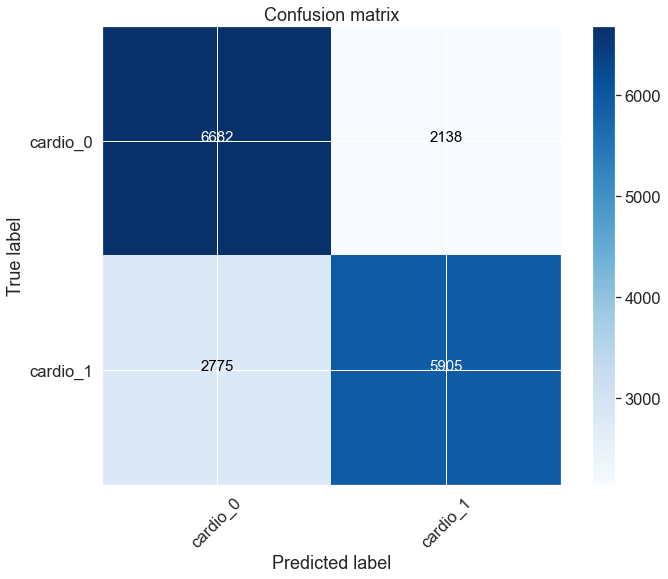


___________________________________________________________________________________
RandomForestClassifier
Наилучшие параметры {'max_depth': 10, 'n_estimators': 200}
mean y_score is  0.431
Precision = 0.767
Recall    = 0.666
F-score   = 0.713
ROC_AUC   = 0.734
Log_loss  = 9.183
True_pos  = 0.666
False_pos = 0.199
True_neg  = 0.801



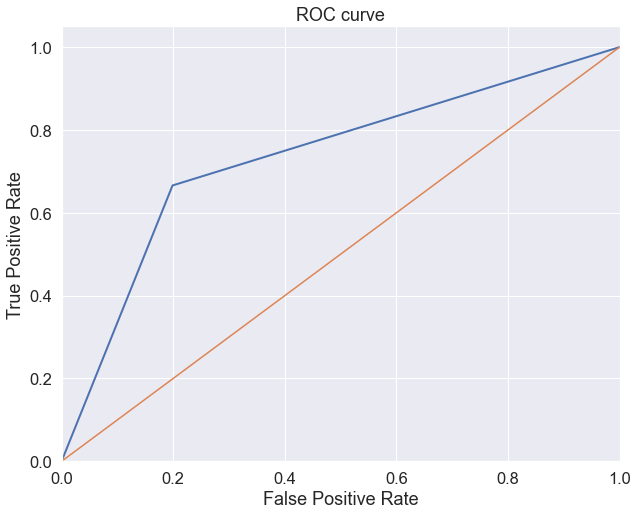

Confusion matrix, without normalization
[[7066 1754]
 [2899 5781]]


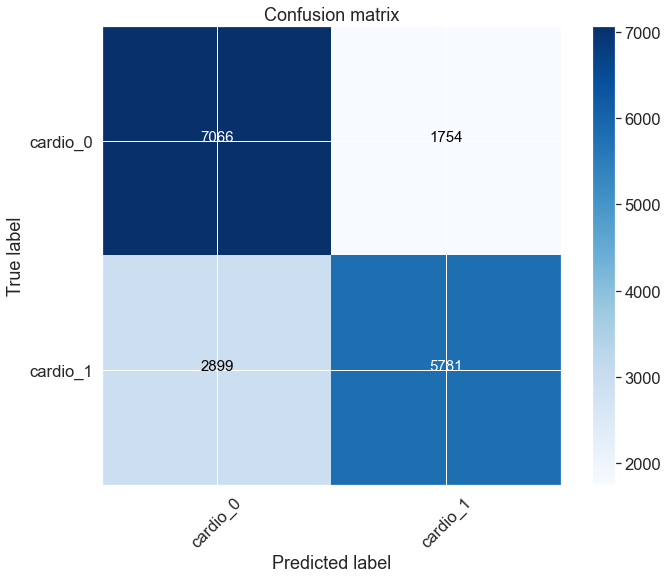


___________________________________________________________________________________
GradientBoostingClassifier
Наилучшие параметры {'max_depth': 2, 'n_estimators': 200}
mean y_score is  0.457
Precision = 0.753
Recall    = 0.693
F-score   = 0.722
ROC_AUC   = 0.735
Log_loss  = 9.158
True_pos  = 0.693
False_pos = 0.224
True_neg  = 0.776



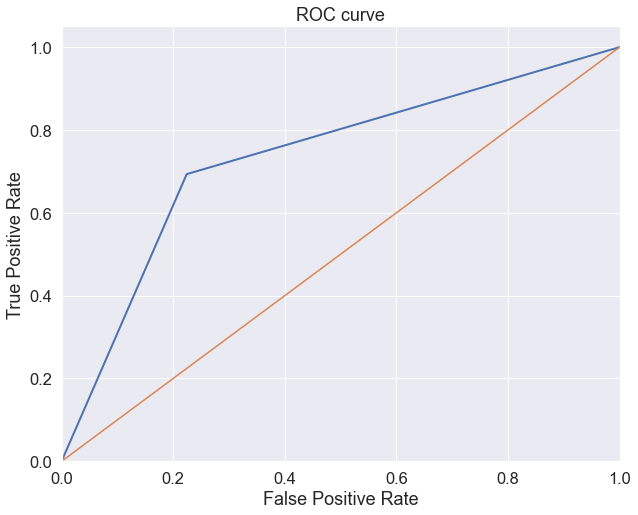

Confusion matrix, without normalization
[[6842 1978]
 [2662 6018]]


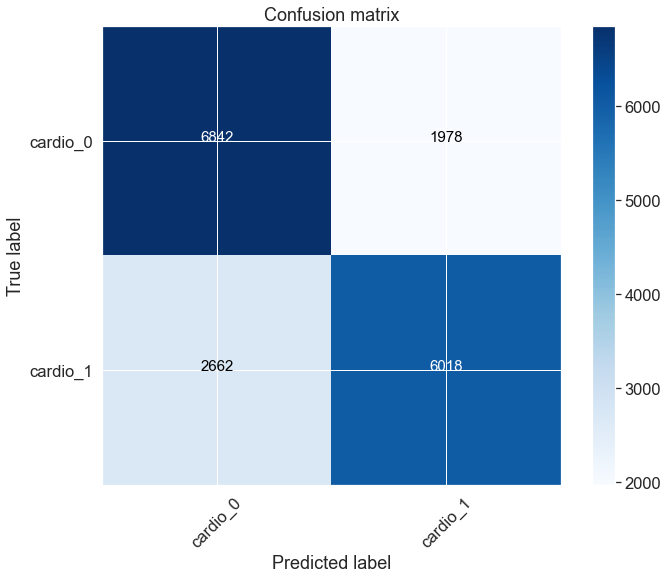


___________________________________________________________________________________
XGBClassifier


C:\_GeekBrain\BigData2021\ML_in_business\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:28:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Наилучшие параметры {'max_depth': 2, 'n_estimators': 100}
mean y_score is  0.456
Precision = 0.753
Recall    = 0.692
F-score   = 0.721
ROC_AUC   = 0.735
Log_loss  = 9.158
True_pos  = 0.692
False_pos = 0.223
True_neg  = 0.777



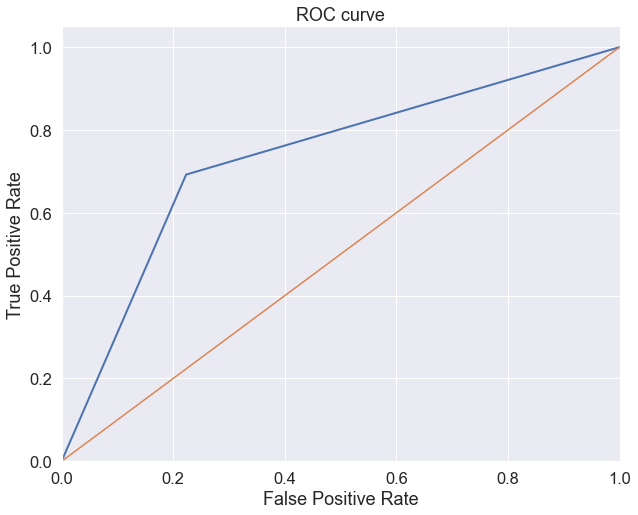

Confusion matrix, without normalization
[[6851 1969]
 [2671 6009]]


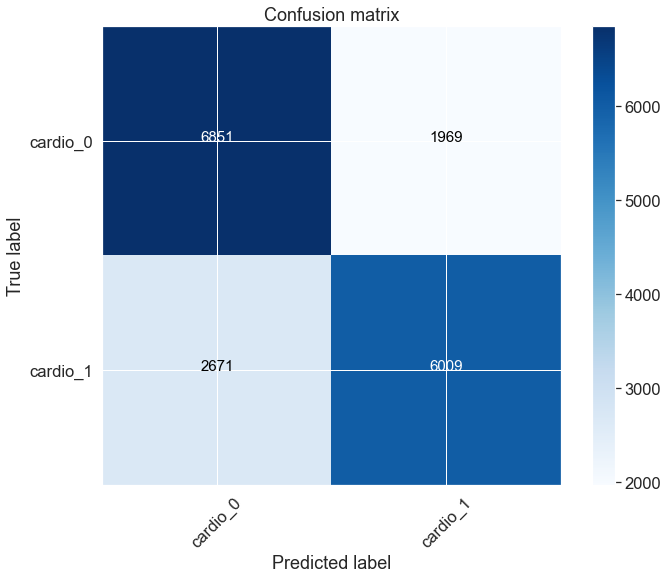


___________________________________________________________________________________
CPU times: total: 31 s
Wall time: 9min 55s


In [9]:
%%time
random_state = 42
b = 1
results = {}
models_names = ['LogisticRegression', 
                'RandomForestClassifier',
                'GradientBoostingClassifier',
                'XGBClassifier']
# print('___________________________________________________________________________________')

for i, model in enumerate([
                           LogisticRegression(random_state=random_state),
                           RandomForestClassifier(random_state=random_state),
                           GradientBoostingClassifier(random_state=random_state),
                           XGBClassifier(random_state=random_state)    
                           ]):
    print(models_names[i])
    
    # узнаем какие гиперпараметры для леса дадут наилучший результат (кроссвалидация - KFold)
    if i == 0:
        params = {"C": np.logspace(-3,3,7), 
                  "penalty": ["l2"]}  # l1 lasso l2 ridge "l1"
    else:
        params = {'n_estimators':[10, 50, 100, 200], 
                  'max_depth':[2, 5, 7, 10]}
    
    gs = GridSearchCV(model, 
                      params, 
                      scoring='r2', 
                      cv=KFold(n_splits=3, random_state=42, shuffle=True), 
                      n_jobs=-1)
    gs.fit(x_train, y_train)
    # наилучшие параметры:
    print('Наилучшие параметры', gs.best_params_)
    y_score = gs.predict(x_test)
    print(f'mean y_score is  {round(np.mean(y_score), 3)}')
    results[models_names[i]] = [y_score, get_scores(y_test, y_score)]
    print()
    print('___________________________________________________________________________________')

In [10]:
# Сравниваем результаты
def df_highlight_max(s):
    '''
    highlight the maximum
    '''
    is_max = s == s.max()
    return ['color: blue' if v else '' for v in is_max]

def df_bold_max(s):
    '''
    bold the maximum
    '''
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

models_acccuracy = pd.DataFrame(columns=models_names)


In [11]:
for i, col in enumerate(models_names):
    if i == 0:
        models_acccuracy = pd.DataFrame.from_dict(results[col][1], orient='index')
    else:
        models_acccuracy = pd.concat([models_acccuracy, 
                                       pd.DataFrame.from_dict(results[col][1], orient='index')],
                                    axis=1)
models_acccuracy.columns = models_names
print('Сравнение качества получившихся данных\nпо столбцам -- модель,\nпо строкам -- метрика,\n\
цветом -- наилучшее значение\n')
models_acccuracy.style.apply(df_highlight_max, axis=1).apply(df_bold_max, axis=1)

Сравнение качества получившихся данных
по столбцам -- модель,
по строкам -- метрика,
цветом -- наилучшее значение



,LogisticRegression,RandomForestClassifier,GradientBoostingClassifier,XGBClassifier
Precision,0.734179,0.767220,0.752626,0.753196
Recall,0.680300,0.666014,0.693318,0.692281
F-score,0.706213,0.713043,0.721756,0.721455
ROC_AUC,0.718948,0.733574,0.734527,0.734519
Log_loss,9.696612,9.183447,9.157800,9.157800
True_pos,0.680300,0.666014,0.693318,0.692281
False_pos,0.242404,0.198866,0.224263,0.223243
True_neg,0.757596,0.801134,0.775737,0.776757


#### Метрики качества градиентного бустинга в целом выше 